In [1]:
from __future__ import division
from ps4_utils import load_data,load_experiment
from ps4_utils import AbstractGenerativeModel
from ps4_utils import save_submission
from scipy.misc import logsumexp
import matplotlib.pyplot as plt
import numpy as np
data_fn = "datasets-ps4.h5"
MAX_OUTER_ITER = 15

In [2]:
def log(x):
    return np.log(x + np.finfo(x.dtype).eps)

def confusion_matrix(Y, T):
    M = np.zeros([T.max() + 1] * 2, dtype=np.int)
    
    for i, t in enumerate(T):
        M[t, Y[i]] += 1
        
    assert (Y == T).sum() == M.trace()
            
    print("Confusion matrix:")
    plt.imshow(M, cmap="gray", interpolation='none')
    plt.show()

In [3]:
class MixtureModel(AbstractGenerativeModel):
    def __init__(self, CLASSES, NUM_FEATURES, NUM_MIXTURE_COMPONENTS, MAX_ITER=50, EPS=10**(-7)):
        AbstractGenerativeModel.__init__(self, CLASSES, NUM_FEATURES)
        self.num_mixture_components = NUM_MIXTURE_COMPONENTS # list of num_mixture_components (length num_classes)
        self.max_iter = MAX_ITER # max iterations of EM
        self.epsilon = EPS # help with stability, to be used according to hint given at end of pset4.pdf
        self.params = { # lists of length CLASSES
            'pi': [np.repeat(1/k,k) for k in self.num_mixture_components], # with pi_c for each class
            'theta': [np.zeros((self.num_features,k)) for k in self.num_mixture_components], # with theta_c for each class
        }
    def pack_params(self, X, class_idx):
        pi,theta = self.fit(X[class_idx],class_idx) # fit parameters
        self.params['pi'][class_idx] = pi # update member variable pi
        self.params['theta'][class_idx] = theta #update member variable theta
        
    #make classification based on which mixture model gives higher probability to generating point xi
    def classify(self, X):
        P = list()
        pi = self.params['pi']
        theta = self.params['theta']
        for c in range(self.num_classes):
            _,Pc = self.findP(X, pi[c], theta[c])
            P.append(Pc)
        return np.vstack(P).T.argmax(-1) # np.array of class predictions for each data point in X

    # --- E-step
    def updateLatentPosterior(self, X, pi, theta): # update the latent posterior
        # YOUR CODE HERE
        # --- gamma: np.array (matrix)
        # ---        shape: number of data points in X (where X consists of datapoints from class c) by NUM_MIXTURE_COMPONENTS[c]
        p, logP = self.findP(X, pi, theta)
        return (p.T / np.e ** logP).T
    # --- M-step (1)
    @staticmethod
    def updatePi(gamma): #update the pi component using the posteriors (gammas)
        # YOUR CODE HERE
        # --- pi_c: class specific pi, np.array (vector)
        # ---        shape: NUM_MIXTURE_COMPONENTS[c]
        return gamma.mean(axis=0)
    # -- M-step (2)
    @staticmethod
    def updateTheta(X, gamma): #update theta component using posteriors (gammas)
        # YOUR CODE HERE
        # --- theta_c: class specific theta, np.array matrix
        # ---        shape: NUM_FEATURES by NUM_MIXTURE_COMPONENTS[c]
        return X.T.dot(gamma) / gamma.sum(axis=0)
    
    @staticmethod
    def findP(X, pi, theta):
        # YOUR CODE HERE
        # --- t: probabilities of x given each component of mixture
        # ---        shape: number of data points in X (where X consists of datapoints from class c) by NUM_MIXTURE_COMPONENTS[c] 
        # --- logsumexp(t,axis=1): normalized by factor of probabilities of x over all components of mixture
        # ---        shape: number of data points in X (where X consists of datapoints from class c)
        t = log(pi) + X.dot(log(theta)) + (1 - X).dot(log(1 - theta))
        return np.e ** t, logsumexp(t, axis=1)
        
    # --- execute EM procedure
    def fit(self, X, class_idx):
        max_iter = self.max_iter
        eps = self.epsilon
        N = X.shape[0]
        pi = self.params['pi'][class_idx]
        theta = self.params['theta'][class_idx]
        num_mixture_components = self.num_mixture_components[class_idx]
        
        # INITIALIZE theta
        components = [[] for _ in range(num_mixture_components)]
        for x in X:
            components[np.random.randint(len(components))].append(x)
        theta = np.array([np.array(component).mean(axis=0) for component in components]).T
        
        for i in range(max_iter):
            # YOUR CODE HERE, E-step: gamma = self.updateLatentPosterior
            gamma = self.updateLatentPosterior(X, pi, theta)
            # YOUR CODE HERE, M-step(1): pi = self.updatePi
            pi = self.updatePi(gamma)
            # YOUR CODE HERE, M-step(2): theta = self.updateTheta
            theta = np.clip(self.updateTheta(X, gamma), self.epsilon, 1 - self.epsilon)
        return pi,theta #pi and theta, given class_idx

In [4]:
class NaiveBayesModel(AbstractGenerativeModel):
    def __init__(self, CLASSES, NUM_FEATURES, EPS=10**(-12)):
        AbstractGenerativeModel.__init__(self, CLASSES, NUM_FEATURES)
        self.epsilon = EPS # help with stability
        self.params = {
            'logp': [np.zeros((NUM_FEATURES))] * self.num_classes # estimated log-probabilities of features for each class
        }
    def pack_params(self, X, class_idx):
        logp = self.fit(X[class_idx])
        self.params['logp'][class_idx] = logp
    def classify(self, X): # naive bayes classifier
        # YOUR CODE HERE
        # --- predictions: predictions for data points in X (where X consists of datapoints from class c), np.array (vector)
        # ---       shape: number of data points
        logp = np.array(self.params['logp'])
        return (X.dot(logp.T) + (1 - X).dot(log(1 - np.e ** logp).T)).argmax(axis=1)
    def fit(self, X):
        # YOUR CODE HERE
        # --- estimated_logp: estimated logp's of features for input X (where X consists of datapoints from class c), np.array (vector)
        # ---          shape: NUM_FEATURES
        return log(X.mean(axis=0))

SENTIMENT ANALYSIS -- NAIVE BAYES MODEL:
ACCURACY ON VALIDATION: 0.72
Confusion matrix:


/home/raviqqe/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((165,), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/raviqqe/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((335,), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/raviqqe/.local/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/raviqqe/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


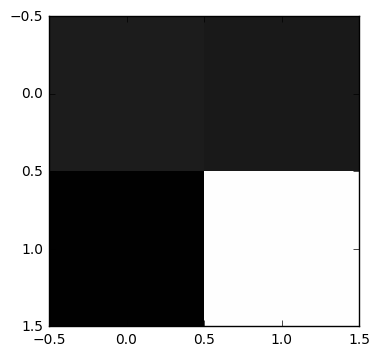

SENTIMENT ANALYSIS -- MIXTURE MODEL:
COMPONENTS: 13 13
ACCURACY ON VALIDATION: 0.69
COMPONENTS: 8 10
ACCURACY ON VALIDATION: 0.718
COMPONENTS: 5 10
ACCURACY ON VALIDATION: 0.7
COMPONENTS: 5 5
ACCURACY ON VALIDATION: 0.734
COMPONENTS: 7 11
ACCURACY ON VALIDATION: 0.706
COMPONENTS: 8 11
ACCURACY ON VALIDATION: 0.744
COMPONENTS: 12 9
ACCURACY ON VALIDATION: 0.714
COMPONENTS: 8 13
ACCURACY ON VALIDATION: 0.704
COMPONENTS: 7 8
ACCURACY ON VALIDATION: 0.724
COMPONENTS: 11 6
ACCURACY ON VALIDATION: 0.734
COMPONENTS: 6 14
ACCURACY ON VALIDATION: 0.696
COMPONENTS: 8 12
ACCURACY ON VALIDATION: 0.71
COMPONENTS: 9 11
ACCURACY ON VALIDATION: 0.726
COMPONENTS: 5 6
ACCURACY ON VALIDATION: 0.738
COMPONENTS: 5 5
ACCURACY ON VALIDATION: 0.704
BEST ACCURACY: 0.744
Saved: mm-sentiment_analysis-submission.csv


In [5]:
experiment_name = "sentiment_analysis"
# --- SENTIMENT ANALYSIS setup
Xtrain,Xval,num_classes,num_features = load_experiment(data_fn, experiment_name)

# -- build naive bayes model for sentiment analysis
print("SENTIMENT ANALYSIS -- NAIVE BAYES MODEL:")
nbm = NaiveBayesModel(num_classes, num_features)
nbm.train(Xtrain)
print("ACCURACY ON VALIDATION: " + str(nbm.val(Xval)))

Y = np.array([])
T = np.array([])

for c in range(num_classes):
    Yc = nbm.classify(Xval[c])
    Y = np.concatenate((Y, Yc))
    T = np.concatenate((T, np.full(Yc.shape, c)))

assert Y.shape == T.shape
confusion_matrix(Y, T)

# -- build mixture model for sentiment analysis
print("SENTIMENT ANALYSIS -- MIXTURE MODEL:")

best_model = None
best_accuracy = None

for i in range(MAX_OUTER_ITER):
    num_mixture_components =  np.random.randint(5,15,num_classes)
    print("COMPONENTS: " + " ".join(str(i) for i in num_mixture_components))
    mm = MixtureModel(num_classes, num_features, num_mixture_components)
    mm.train(Xtrain)
    accuracy = mm.val(Xval)
    print("ACCURACY ON VALIDATION:", accuracy)
    
    if best_accuracy is None or accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = mm

print("BEST ACCURACY:", best_accuracy)

# submit to kaggle
Xkaggle = load_data(data_fn, experiment_name, "kaggle")
save_submission("mm-{}-submission.csv".format(experiment_name), best_model.classify(Xkaggle))

MNIST DIGIT CLASSIFICATION -- NAIVE BAYES MODEL:
ACCURACY ON VALIDATION: 0.733
Confusion matrix:


/home/raviqqe/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((187,), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/raviqqe/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((223,), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/raviqqe/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((210,), 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/raviqqe/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((183,), 3) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/raviqqe/.local/lib/python3.5/site-packages/numpy/core/numeric.py:301: Futu

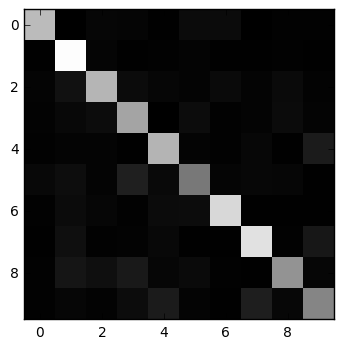

MNIST DIGIT CLASSIFICATION -- MIXTURE MODEL:
COMPONENTS: 13 10 13 6 8 14 12 10 11 5
ACCURACY ON VALIDATION: 0.7745
COMPONENTS: 14 8 5 6 12 14 14 5 6 9
ACCURACY ON VALIDATION: 0.7895
COMPONENTS: 12 13 6 7 8 13 14 14 10 7
ACCURACY ON VALIDATION: 0.7745
COMPONENTS: 7 12 8 8 7 14 13 10 12 6
ACCURACY ON VALIDATION: 0.769
COMPONENTS: 11 6 7 9 12 8 5 13 5 9
ACCURACY ON VALIDATION: 0.7845
COMPONENTS: 7 8 14 10 13 9 14 12 6 13
ACCURACY ON VALIDATION: 0.7815
COMPONENTS: 9 6 8 5 9 8 12 12 9 12
ACCURACY ON VALIDATION: 0.7805
COMPONENTS: 13 13 6 9 9 11 6 6 14 6
ACCURACY ON VALIDATION: 0.785
COMPONENTS: 11 5 11 6 8 8 5 6 7 5
ACCURACY ON VALIDATION: 0.7965
COMPONENTS: 12 8 5 12 14 5 14 8 11 9
ACCURACY ON VALIDATION: 0.798
COMPONENTS: 11 6 8 14 5 10 9 14 11 13
ACCURACY ON VALIDATION: 0.7835
COMPONENTS: 7 9 13 7 8 6 8 14 5 11
ACCURACY ON VALIDATION: 0.786
COMPONENTS: 7 6 12 7 8 10 8 9 11 5
ACCURACY ON VALIDATION: 0.7845
COMPONENTS: 13 10 9 6 12 5 14 14 5 12
ACCURACY ON VALIDATION: 0.7815
COMPONENTS: 6 

In [7]:
experiment_name = "mnist"
# --- MNIST DIGIT CLASSIFICATION setup
Xtrain,Xval,num_classes,num_features = load_experiment(data_fn, experiment_name)

# -- build naive bayes model for mnist digit classification
print("MNIST DIGIT CLASSIFICATION -- NAIVE BAYES MODEL:")
nbm = NaiveBayesModel(num_classes, num_features)
nbm.train(Xtrain)
print("ACCURACY ON VALIDATION: " + str(nbm.val(Xval)))

Y = np.array([])
T = np.array([])

for c in range(num_classes):
    Yc = nbm.classify(Xval[c])
    Y = np.concatenate((Y, Yc))
    T = np.concatenate((T, np.full(Yc.shape, c)))

confusion_matrix(Y, T)

# -- build mixture model for mnist digit classification
print("MNIST DIGIT CLASSIFICATION -- MIXTURE MODEL:")

best_model = None
best_accuracy = None

for i in range(MAX_OUTER_ITER):
    num_mixture_components =  np.random.randint(5,15,num_classes)
    print("COMPONENTS: " + " ".join(str(i) for i in num_mixture_components))
    mm = MixtureModel(num_classes, num_features, num_mixture_components)
    mm.train(Xtrain)
    accuracy = mm.val(Xval)
    print("ACCURACY ON VALIDATION:", accuracy)
    
    if best_accuracy is None or accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = mm

print("BEST ACCURACY:", best_accuracy)

# submit to kaggle
Xkaggle = load_data(data_fn, experiment_name, "kaggle")
save_submission("mm-{}-submission.csv".format(experiment_name), best_model.classify(Xkaggle))